In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv('GBPUSD_open_5year.csv')

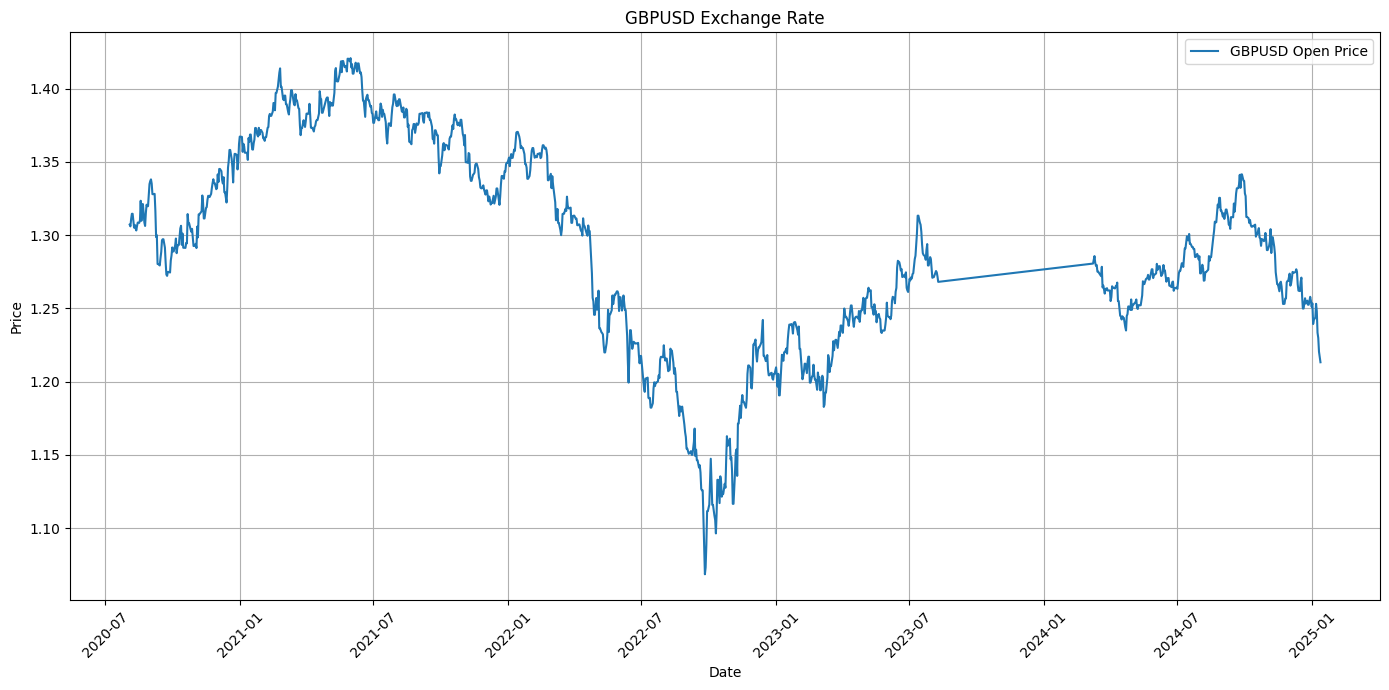

In [3]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Open'], label='GBPUSD Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GBPUSD Exchange Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [4]:
df.set_index('Date', inplace=True)

In [5]:
# Splitting dataset
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

print(f"Training Data: {train_data.shape}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")

Training Data: (840, 3)
Validation Data: (180, 3)
Test Data: (180, 3)


In [6]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[['Open', 'Time']])

X_train_scaled = scaler.transform(train_data[['Open', 'Time']])
X_val_scaled = scaler.transform(val_data[['Open', 'Time']])
X_test_scaled = scaler.transform(test_data[['Open', 'Time']])

y_train = train_data['Open'].values
y_val = val_data['Open'].values
y_test = test_data['Open'].values

In [7]:
def time_sequence_generator(X, y, time_interval):
    X_range, y_range = [], []
    for i in range(len(X) - time_interval):
        X_range.append(X[i:i+time_interval])
        y_range.append(y[i+time_interval])
    return np.array(X_range), np.array(y_range)

In [8]:
time_interval= 60

X_train_seq, y_train_seq = time_sequence_generator(X_train_scaled, y_train, time_interval)
X_val_seq, y_val_seq = time_sequence_generator(X_val_scaled, y_val, time_interval)
X_test_seq, y_test_seq = time_sequence_generator(X_test_scaled, y_test, time_interval)

print(f"Shape of X_train: {X_train_seq.shape}")
print(f"Shape of X_val: {X_val_seq.shape}")
print(f"Shape of X_test: {X_test_seq.shape}")

Shape of X_train: (780, 60, 2)
Shape of X_val: (120, 60, 2)
Shape of X_test: (120, 60, 2)


In [9]:
# Build RNN model
rnn_model = Sequential()


rnn_model.add(SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(time_interval, 2)))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(units=32, activation='relu', return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(units=16, activation='relu'),)
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(units=8, activation='relu'))
#output
rnn_model.add(Dense(units=1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

history = rnn_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_val_seq, y_val_seq))

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.2633 - mae: 1.0739 - mse: 1.2633 - val_loss: 0.0354 - val_mae: 0.1667 - val_mse: 0.0354
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2176 - mae: 0.3695 - mse: 0.2176 - val_loss: 0.0178 - val_mae: 0.1138 - val_mse: 0.0178
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1739 - mae: 0.3332 - mse: 0.1739 - val_loss: 0.0296 - val_mae: 0.1449 - val_mse: 0.0296
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1261 - mae: 0.2805 - mse: 0.1261 - val_loss: 0.0533 - val_mae: 0.2057 - val_mse: 0.0533
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1476 - mae: 0.3032 - mse: 0.1476 - val_loss: 0.0136 - val_mae: 0.0998 - val_mse: 0.0136
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1147 - mae: 0.2609 - mse: 0.1147 - val_loss: 0.0040 - val_mae: 0.0563 - val_mse: 0.0040
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0978 - mae: 0.2385 - mse: 0.0978 - val

In [10]:
# Evaluate
test_loss = rnn_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss (RNN): {test_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0281 - mae: 0.1665 - mse: 0.0281
Test Loss (RNN): [0.02483389712870121, 0.1558772772550583, 0.02483389712870121]


In [ ]:
# Predictions
y_pred = rnn_model.predict(X_test_seq)

y_pred = scaler.inverse_transform(np.column_stack((y_pred, np.zeros(y_pred.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test_seq.reshape(-1, 1), np.zeros(y_test_seq.shape))))[:, 0]

mae_rnn = mean_absolute_error(y_test_actual, y_pred)
mse_rnn = mean_squared_error(y_test_actual, y_pred)
r2_rnn = r2_score(y_test_actual, y_pred)
mape_rnn = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


In [12]:
print(f"RNN Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_rnn:.4f}")
print(f"Mean Squared Error (MSE): {mse_rnn:.4f}")
print(f"R² Score: {r2_rnn:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rnn:.2f}%")

RNN Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0549
Mean Squared Error (MSE): 0.0031
R² Score: -27.1496
Mean Absolute Percentage Error (MAPE): 3.61%


In [ ]:

X_full_scaled = scaler.transform(df[['Open', 'Time']])
X_val_scaled = scaler.transform([['Open', 'Time']])
X_test_scaled = scaler.transform(test_data[['Open', 'Time']])

y_train = train_data['Open'].values
y_val = val_data['Open'].values
y_test = test_data['Open'].values

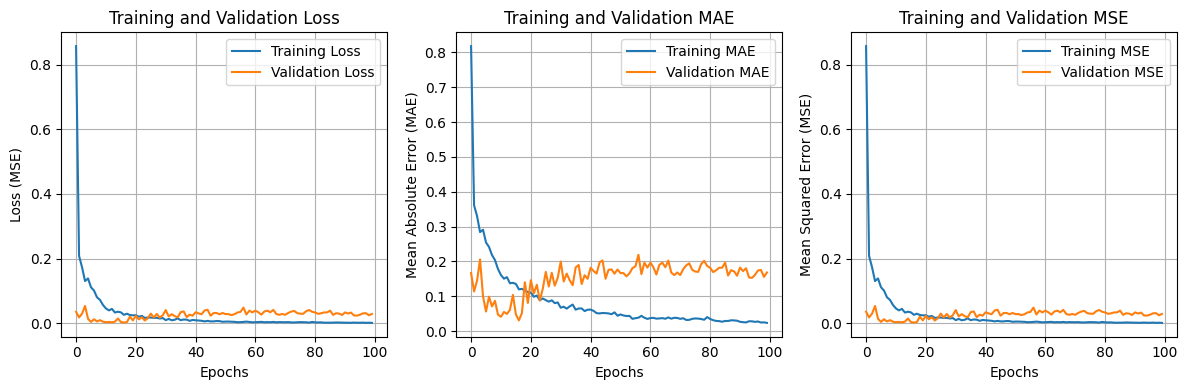

In [13]:
# Plot Training History
history_dict = history.history

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()